## Imports

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


## Verify Data Integrity

In [3]:


# Load the CSV files into DataFrames
os.chdir('..')
print("Current working directory:", os.getcwd())
df = pd.read_csv('Data/bills.csv')
venues_df = pd.read_csv('Data/venues.csv')

# Merge the DataFrames on the 'venue_xref_id' column
df = df.merge(venues_df, on='venue_xref_id', how='left')

# Display the first few rows of the DataFrame
df.head()

Current working directory: c:\Users\Natha\Documents\GitHub\TouchBistroEDA


bill_paid_at_local  bill_total_billed  bill_total_discount_item_level  \
0  2024-07-01 09:17:01              21.81                             0.0   
1  2024-07-01 13:37:00              48.95                             0.0   
2  2024-07-01 11:19:32              26.94                             0.0   
3  2024-07-01 15:05:59               3.96                             0.0   
4  2024-07-01 12:41:00               3.36                             0.0   

   bill_total_gratuity  bill_total_net  bill_total_tax  bill_total_voided  \
0                  0.0           19.30            2.51                0.0   
1                  0.0           43.32            5.63                0.0   
2                  0.0           23.84            3.10                0.0   
3                  0.0            3.77            0.19                0.0   
4                  0.0            3.20            0.16                0.0   

                                           bill_uuid business_date  \
0  240701091701~4D63608F-523C-4EFF-9A4F-78D6C44B5159    2024-07-01   
1  240701133659~3A0BEDE2-E9E5-484D-B909-780E485F0D69    2024-07-01   
2  240701111931~670EEB85-E939-4924-B92F-C95076B7E930    2024-07-01   
3  240701150558~3D6F473E-D5EF-4BB8-AFAB-30DB2A0764C0    2024-07-01   
4  240701124059~0521794C-51FC-4C30-A368-995CE4DE105F    2024-07-01   

   order_duration_seconds  ... payment_amount payment_count payment_total_tip  \
0                      46  ...          21.81             1               0.0   
1                     288  ...          48.95             1               0.0   
2                     135  ...          26.94             1               0.0   
3                      48  ...           3.96             1               0.0   
4                     103  ...           3.36             1               0.0   

  sales_revenue_with_tax                                      venue_xref_id  \
0                  21.81  39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...   
1                  48.95  39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...   
2                  26.94  39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...   
3                   3.96  39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...   
4                   3.36  39e5b4830d4d9c14db7368a95b65d5463ea3d095203737...   

                                         waiter_uuid  concept         city  \
0  161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD      NaN  Collingwood   
1  161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD      NaN  Collingwood   
2  161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD      NaN  Collingwood   
3  161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD      NaN  Collingwood   
4  161027134744~719D0E09-5CA7-442A-B9FA-BBBF4083B4FD      NaN  Collingwood   

  country start_of_day_offset  
0      CA            00:00:00  
1      CA            00:00:00  
2      CA            00:00:00  
3      CA            00:00:00  
4      CA            00:00:00  

[5 rows x 24 columns]

## Check for Outliers for Innacurate Order Duration

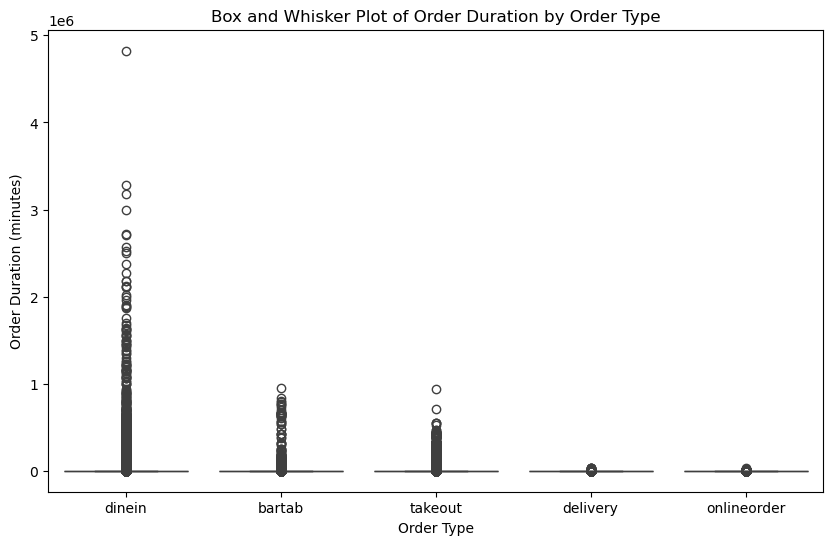

In [5]:

# Convert order duration from seconds to minutes
df['order_duration_minutes'] = df['order_duration_seconds'] / 60

# Create a box and whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_take_out_type_label', y='order_duration_minutes', data=df)
plt.title('Box and Whisker Plot of Order Duration by Order Type')
plt.xlabel('Order Type')
plt.ylabel('Order Duration (minutes)')
plt.show()


## Check where the Outliers Begin

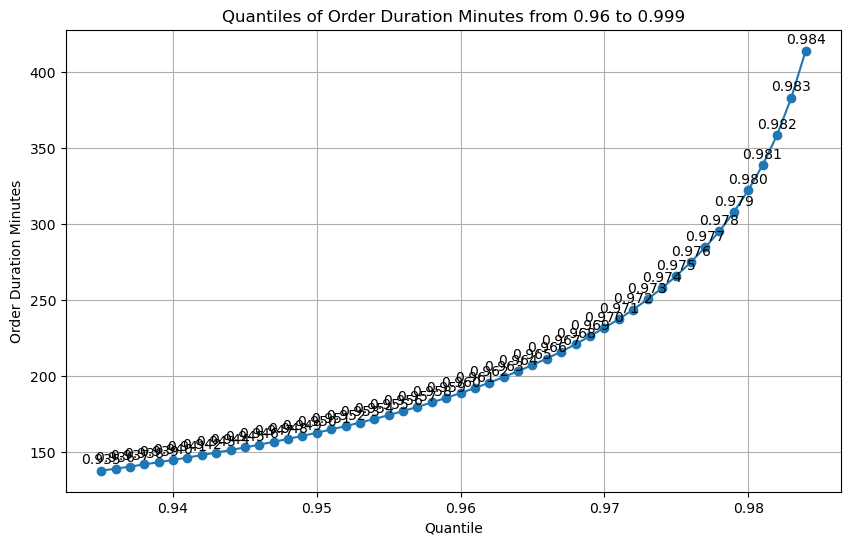

In [6]:

# Calculate quantiles from 0.96 to 0.999 in 0.001 increments
quantiles = np.arange(0.935, 0.985, 0.001)
quantile_values = [df['order_duration_minutes'].quantile(q) for q in quantiles]

# Plot the quantiles
plt.figure(figsize=(10, 6))
plt.plot(quantiles, quantile_values, marker='o')

# Annotate each point with the quantile number
for i, q in enumerate(quantiles):
    plt.annotate(f'{q:.3f}', (q, quantile_values[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.title('Quantiles of Order Duration Minutes from 0.96 to 0.999')
plt.xlabel('Quantile')
plt.ylabel('Order Duration Minutes')
plt.grid(True)
plt.show()

### Data is Valid Until 0.994

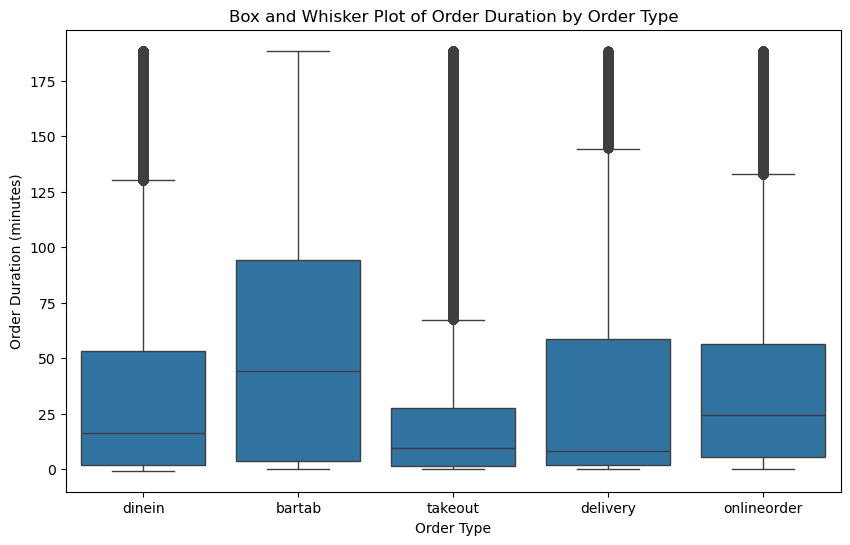

In [7]:


# Filter out rows where order_duration_minutes is greater than 180
filtered_df = df[df['order_duration_minutes'] <= df['order_duration_minutes'].quantile(0.96)]

# Create a box and whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_take_out_type_label', y='order_duration_minutes', data=filtered_df)
plt.title('Box and Whisker Plot of Order Duration by Order Type')
plt.xlabel('Order Type')
plt.ylabel('Order Duration (minutes)')
plt.show()


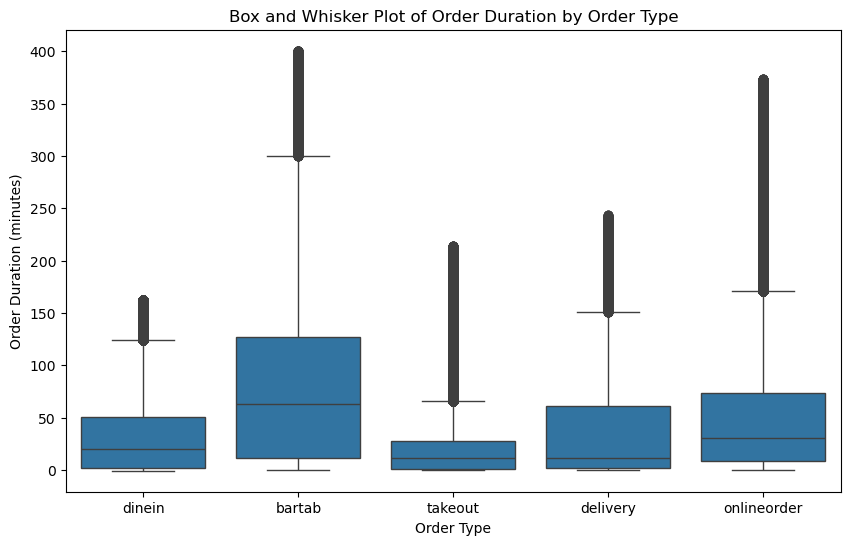

In [8]:


# Calculate the 0.96 quantile for each order type
quantile_96_per_type = df.groupby('order_take_out_type_label')['order_duration_minutes'].quantile(0.96)

# Calculate the median for each order type
median_per_type = df.groupby('order_take_out_type_label')['order_duration_minutes'].median()

# Replace excluded data points with the respective median for each order type
df['order_duration_minutes'] = df.apply(
    lambda row: median_per_type[row['order_take_out_type_label']] if row['order_duration_minutes'] > quantile_96_per_type[row['order_take_out_type_label']] else row['order_duration_minutes'],
    axis=1
)

# Create a box and whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='order_take_out_type_label', y='order_duration_minutes', data=df)
plt.title('Box and Whisker Plot of Order Duration by Order Type')
plt.xlabel('Order Type')
plt.ylabel('Order Duration (minutes)')
plt.show()


### Time-Series Frequency Analysis

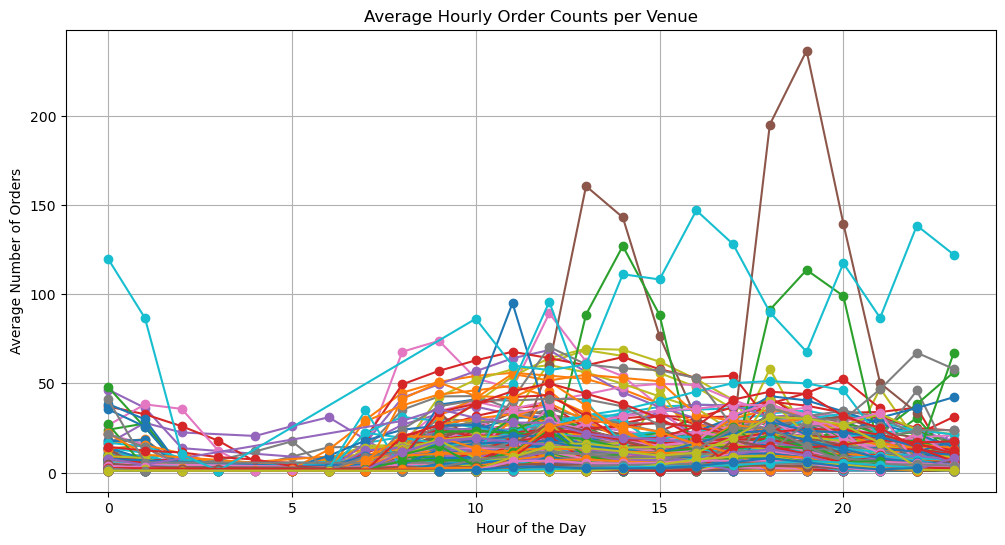

In [9]:
# Create a time series DataFrame from the existing filtered_df
time_series_df = filtered_df[['order_seated_at_local', 'order_uuid', 'venue_xref_id', 'business_date']].copy()
time_series_df.set_index('order_seated_at_local', inplace=True)
time_series_df.index = pd.to_datetime(time_series_df.index)  # Ensure the index is a DatetimeIndex
time_series_df['order_count'] = 1

# Extract the hour from the datetime index
time_series_df['hour'] = time_series_df.index.hour

# Group by venue, business date, and hour, then sum the order counts
hourly_order_counts = time_series_df.groupby(['venue_xref_id', 'business_date', 'hour'])['order_count'].sum().reset_index()

# Calculate the average order count per hour for each venue
average_hourly_order_counts = hourly_order_counts.groupby(['venue_xref_id', 'hour'])['order_count'].mean().reset_index()

# Plot the average hourly order counts for each venue
plt.figure(figsize=(12, 6))
for venue in average_hourly_order_counts['venue_xref_id'].unique():
    venue_data = average_hourly_order_counts[average_hourly_order_counts['venue_xref_id'] == venue]
    plt.plot(venue_data['hour'], venue_data['order_count'], marker='o', label=venue)

plt.title('Average Hourly Order Counts per Venue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Orders')
# plt.legend(title='Venue')
plt.grid(True)
plt.show()


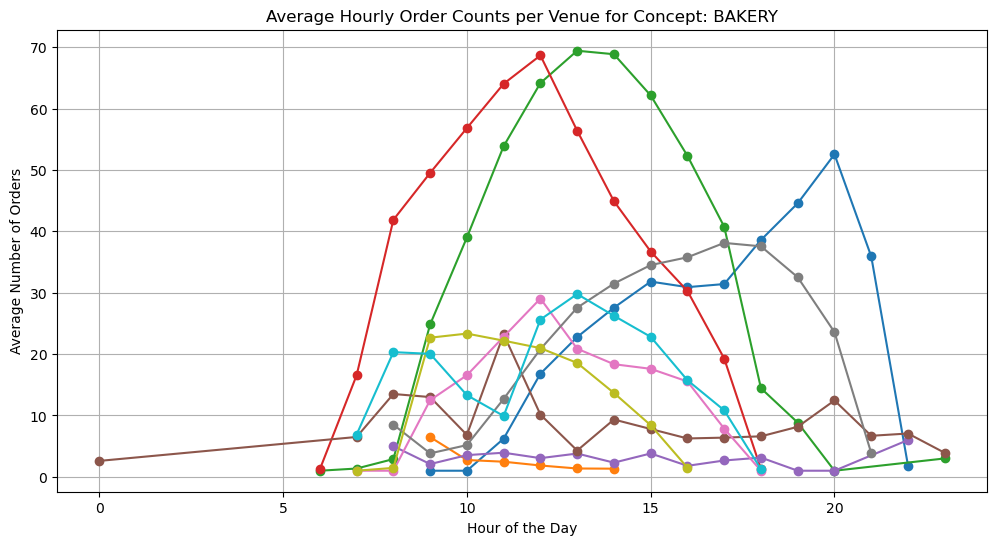

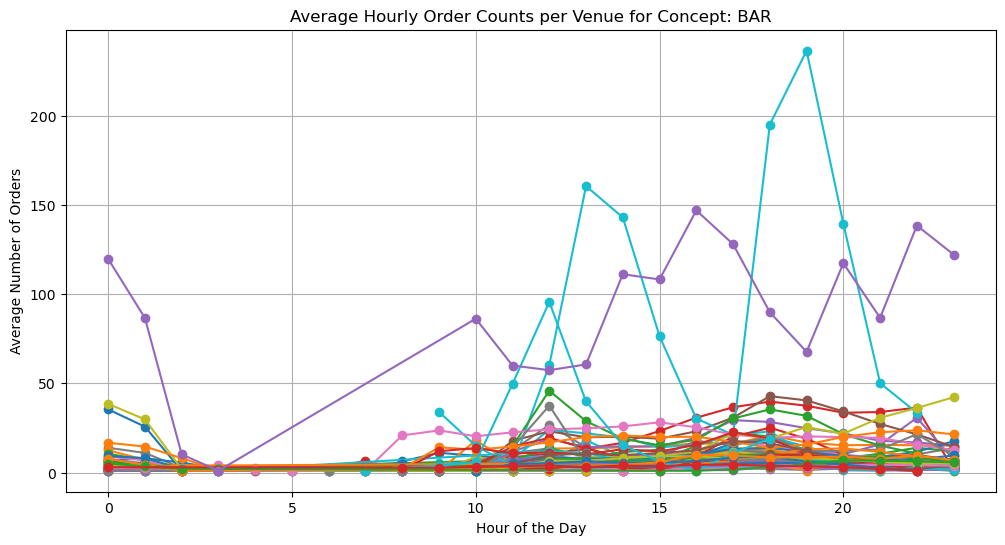

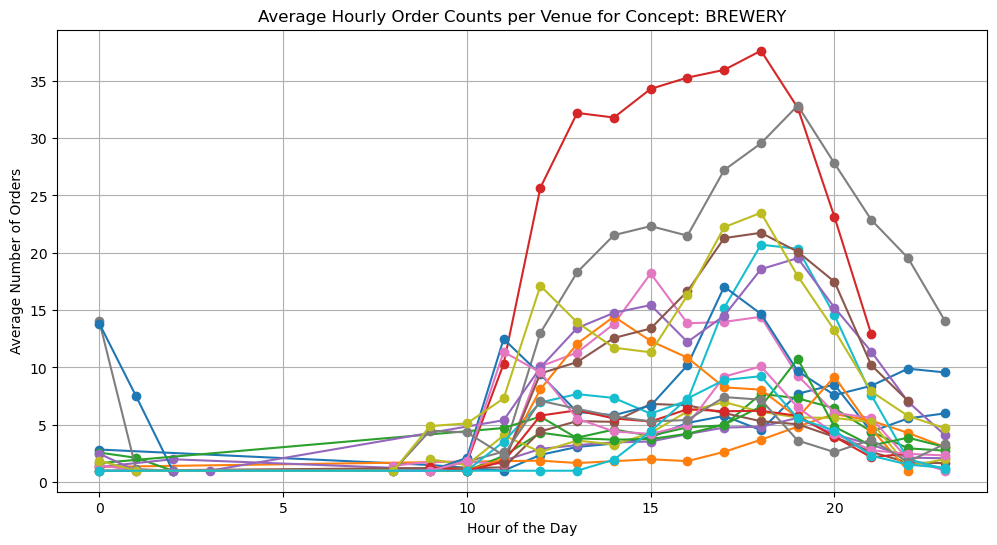

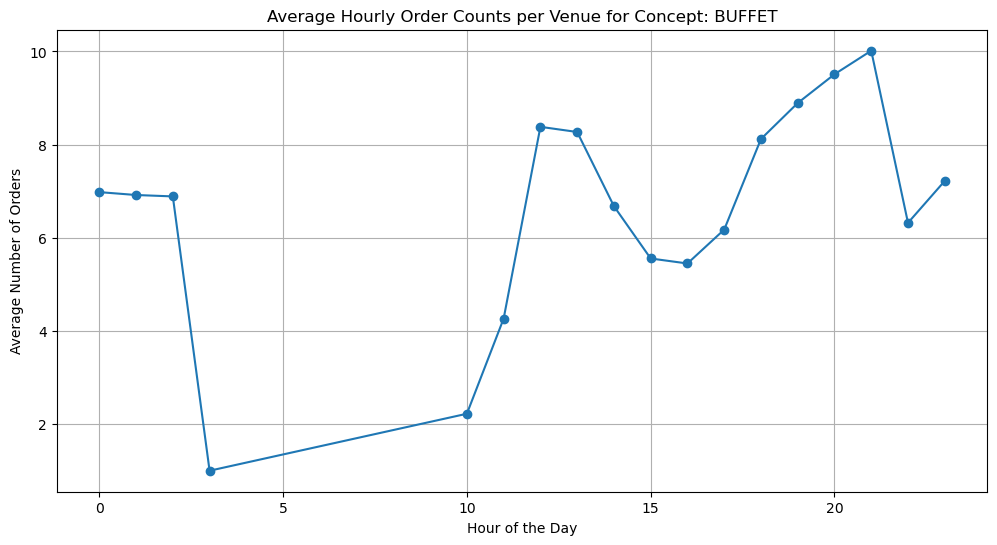

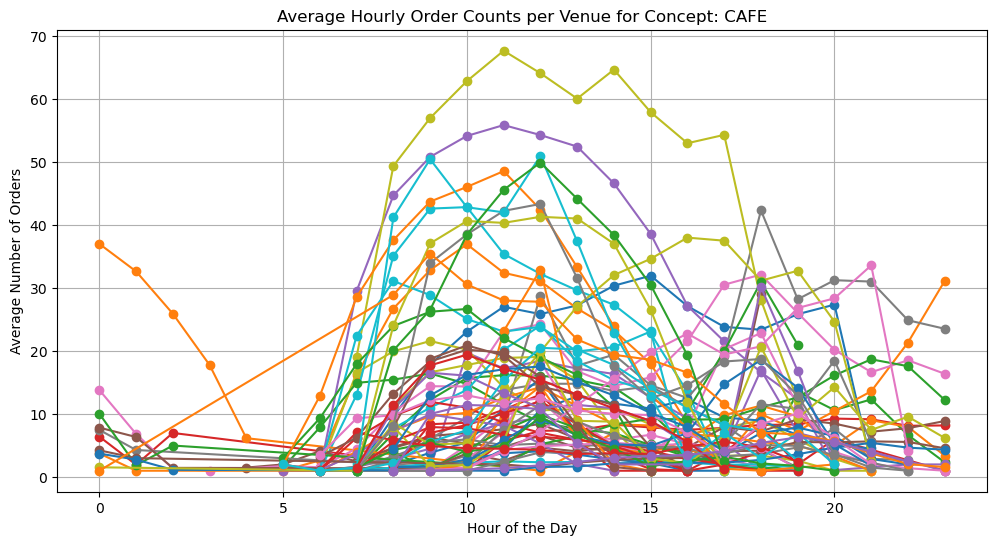

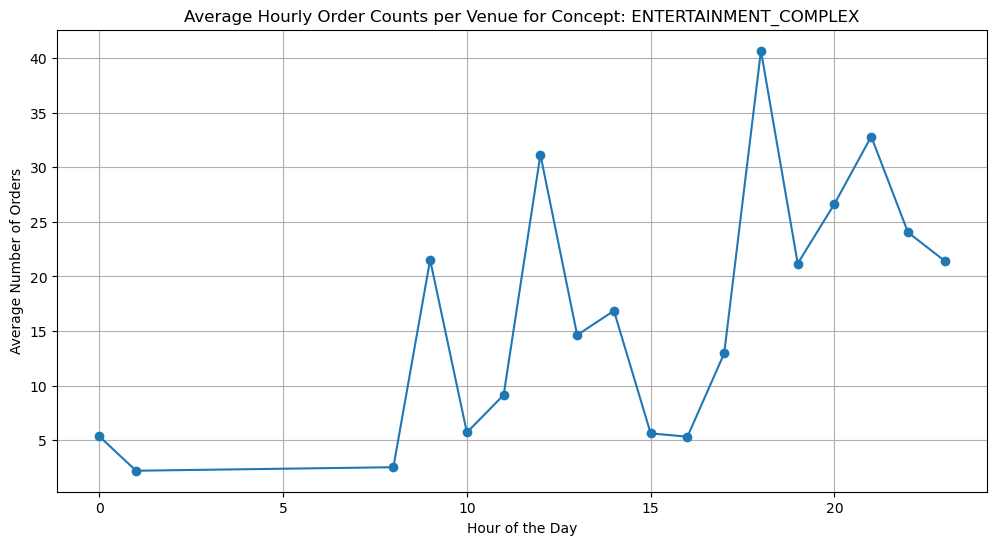

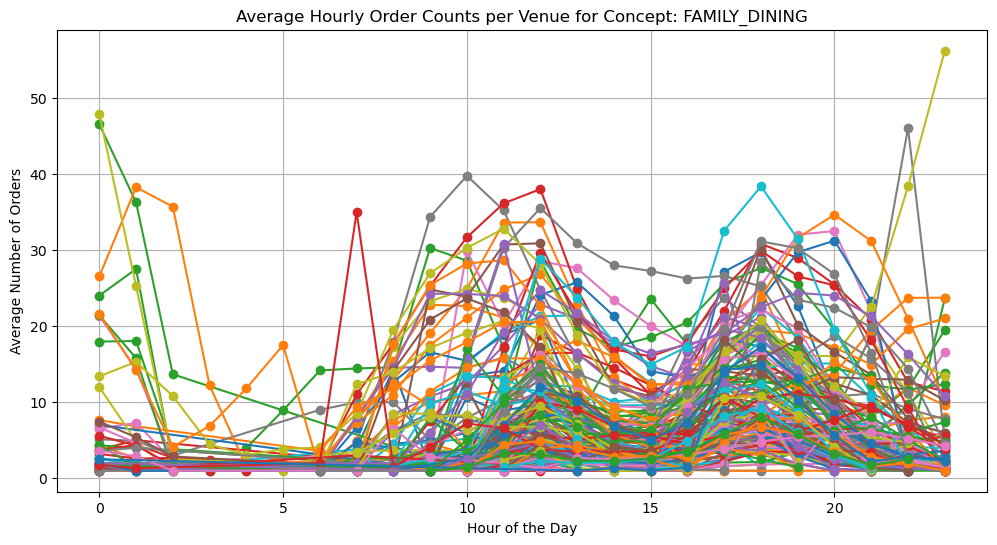

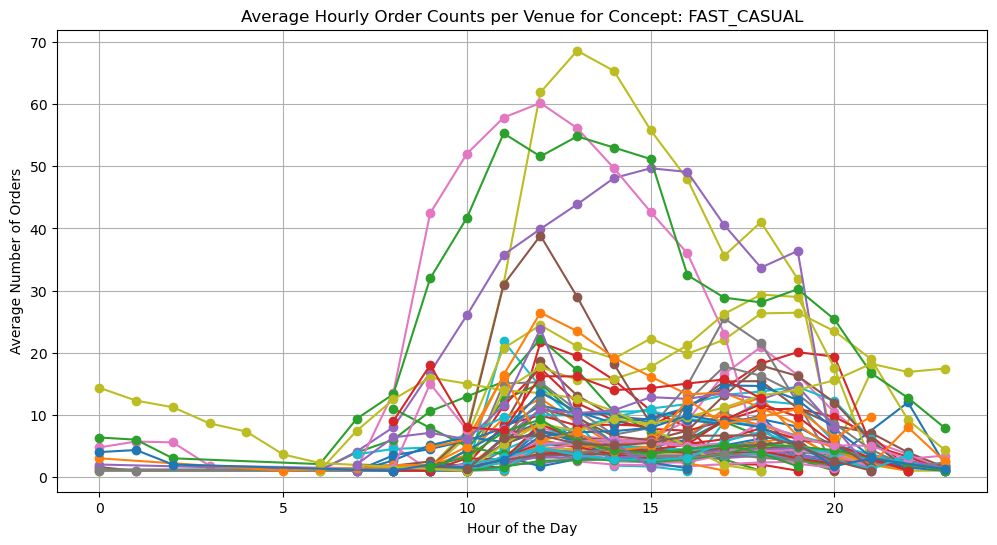

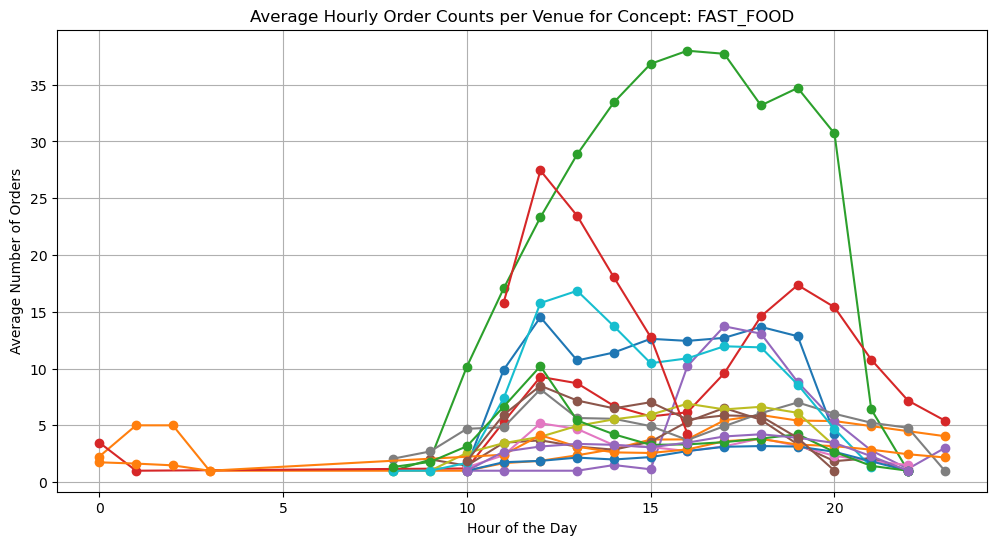

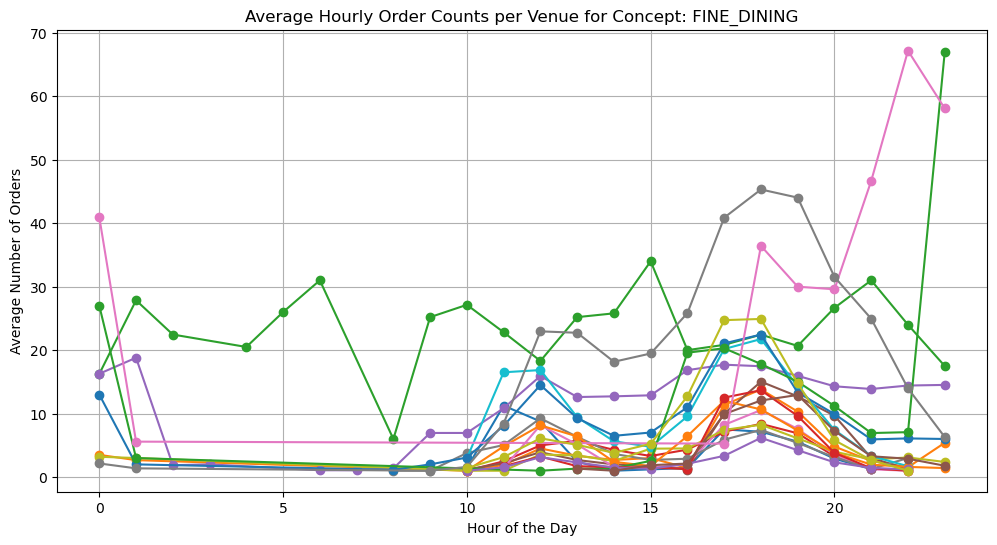

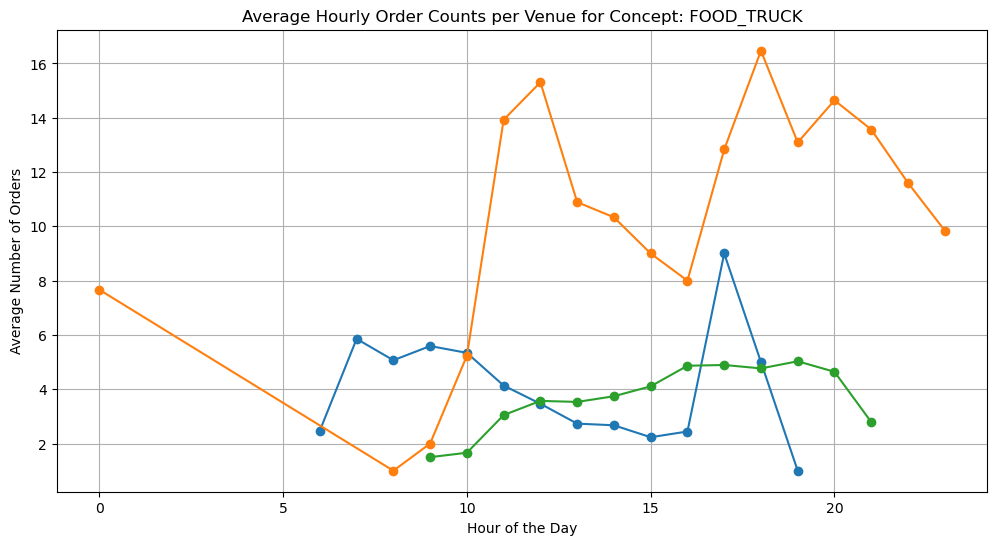

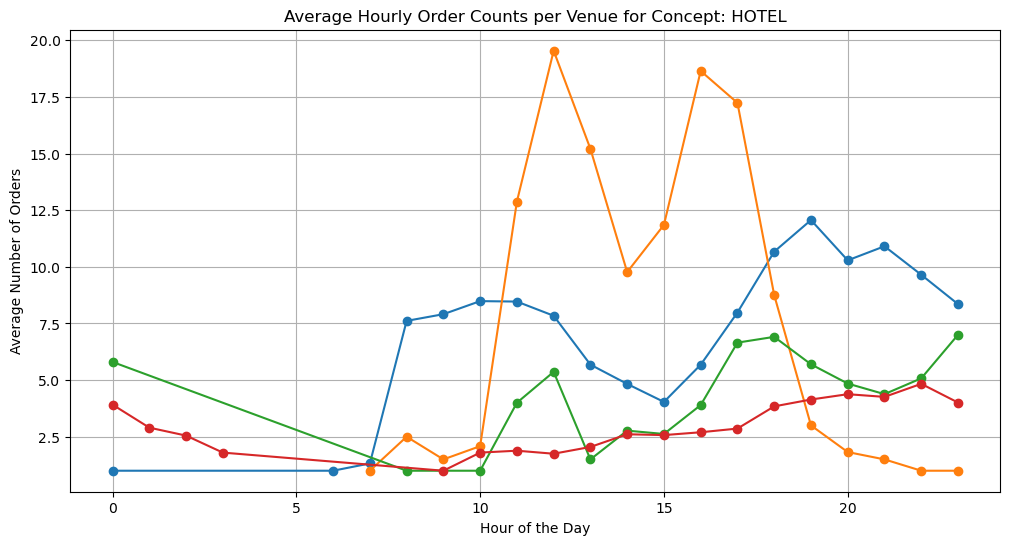

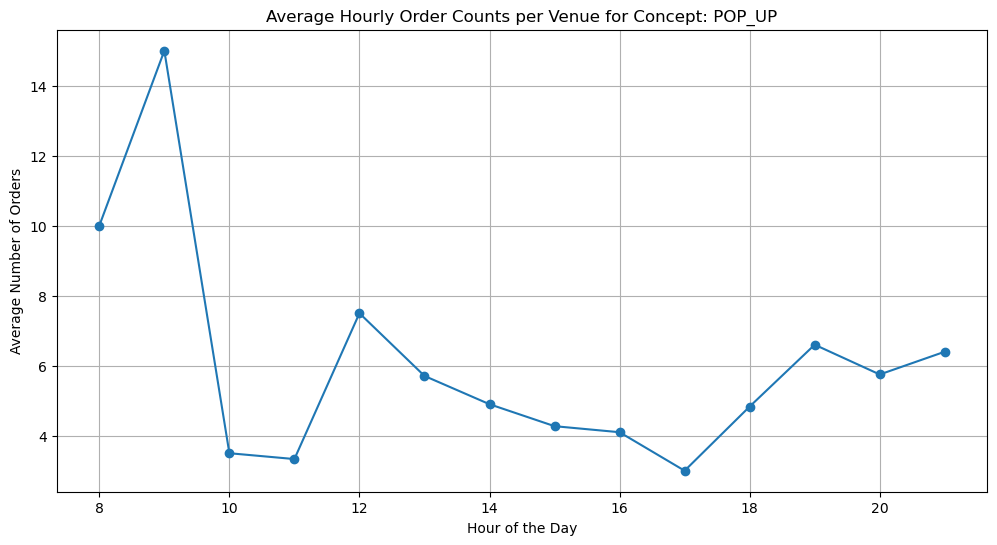

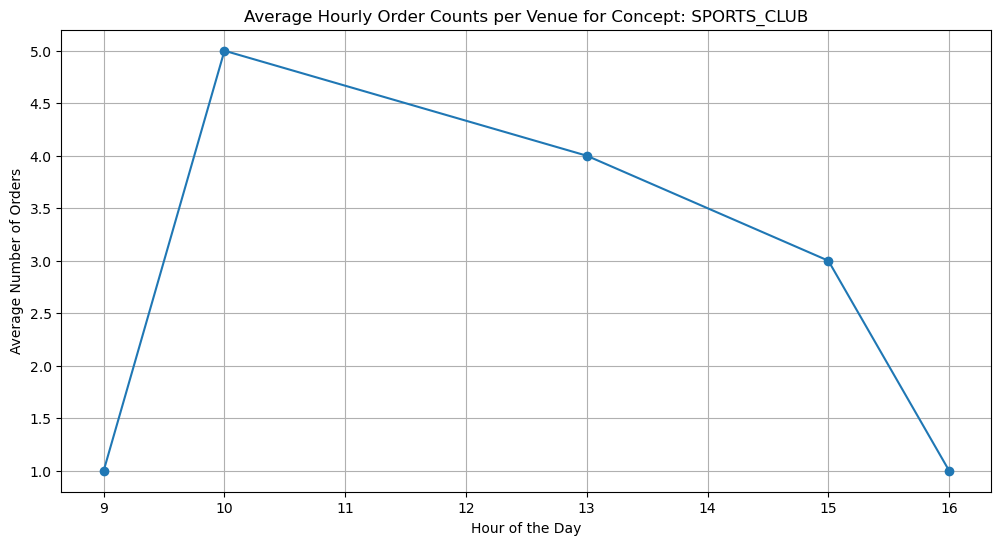

In [10]:
# Create a time series DataFrame from the existing filtered_df
time_series_df = filtered_df[['order_seated_at_local', 'order_uuid', 'venue_xref_id', 'business_date', 'concept']].copy()
time_series_df.set_index('order_seated_at_local', inplace=True)
time_series_df.index = pd.to_datetime(time_series_df.index)  # Ensure the index is a DatetimeIndex
time_series_df['order_count'] = 1

# Extract the hour from the datetime index
time_series_df['hour'] = time_series_df.index.hour

# Group by concept, venue, business date, and hour, then sum the order counts
hourly_order_counts = time_series_df.groupby(['concept', 'venue_xref_id', 'business_date', 'hour'])['order_count'].sum().reset_index()

# Calculate the average order count per hour for each concept and venue
average_hourly_order_counts = hourly_order_counts.groupby(['concept', 'venue_xref_id', 'hour'])['order_count'].mean().reset_index()

# Plot the average hourly order counts for each concept and venue
concepts = average_hourly_order_counts['concept'].unique()
for concept in concepts:
    plt.figure(figsize=(12, 6))
    concept_data = average_hourly_order_counts[average_hourly_order_counts['concept'] == concept]
    for venue in concept_data['venue_xref_id'].unique():
        venue_data = concept_data[concept_data['venue_xref_id'] == venue]
        plt.plot(venue_data['hour'], venue_data['order_count'], marker='o', label=venue)
    
    plt.title(f'Average Hourly Order Counts per Venue for Concept: {concept}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Average Number of Orders')
    # plt.legend(title='Venue')
    plt.grid(True)
    plt.show()


## Normalization

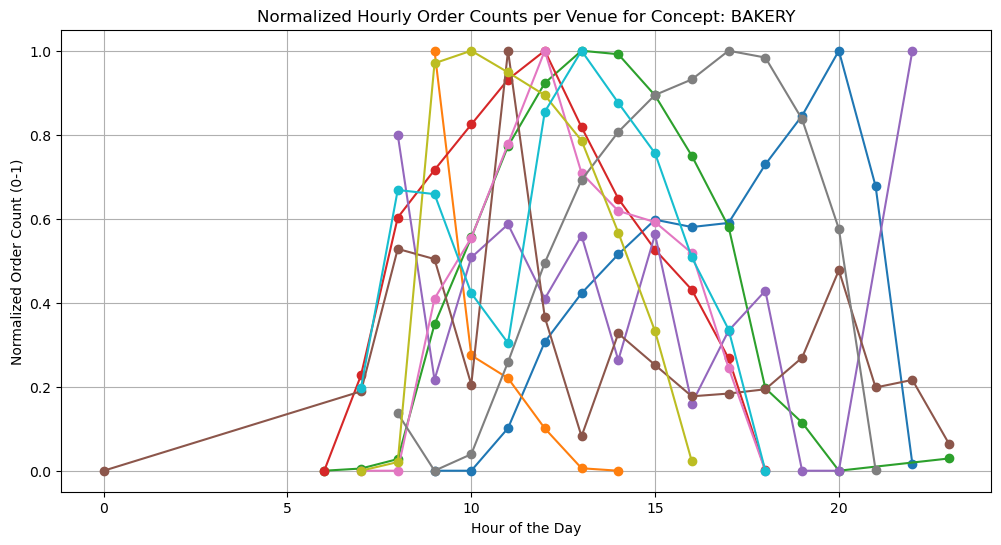

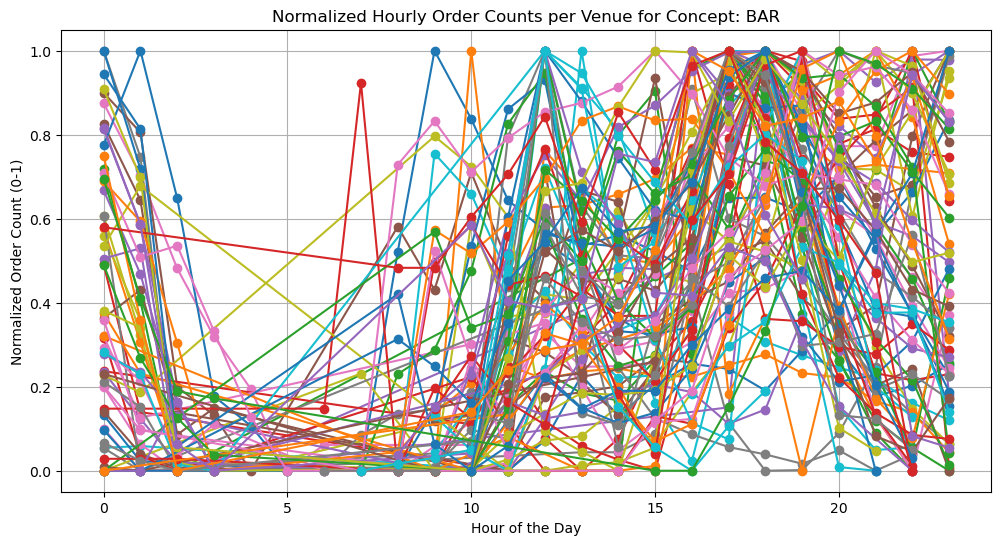

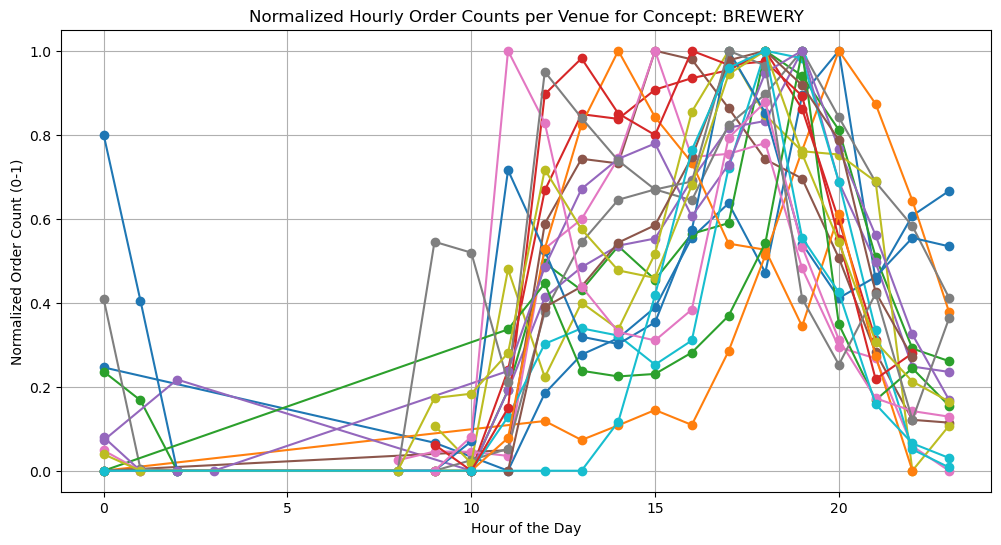

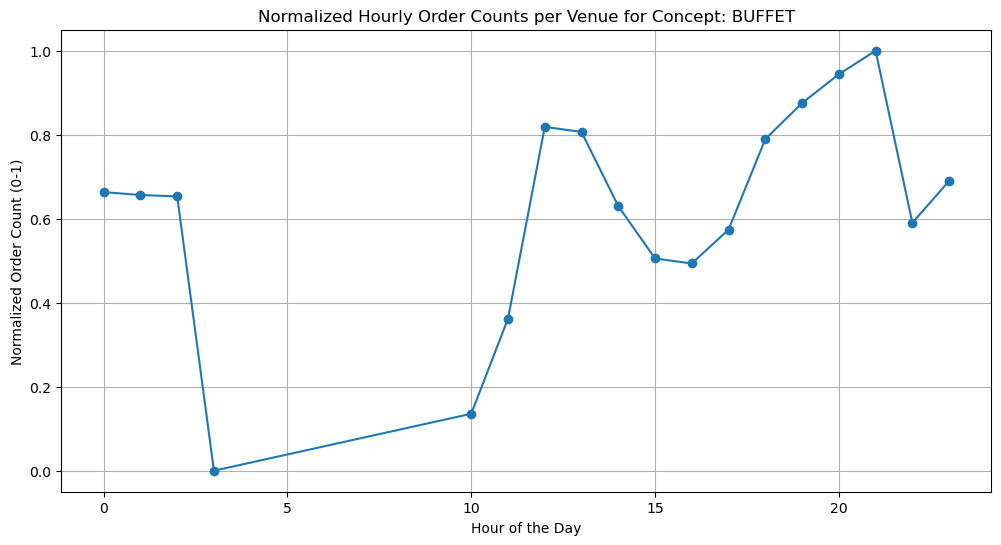

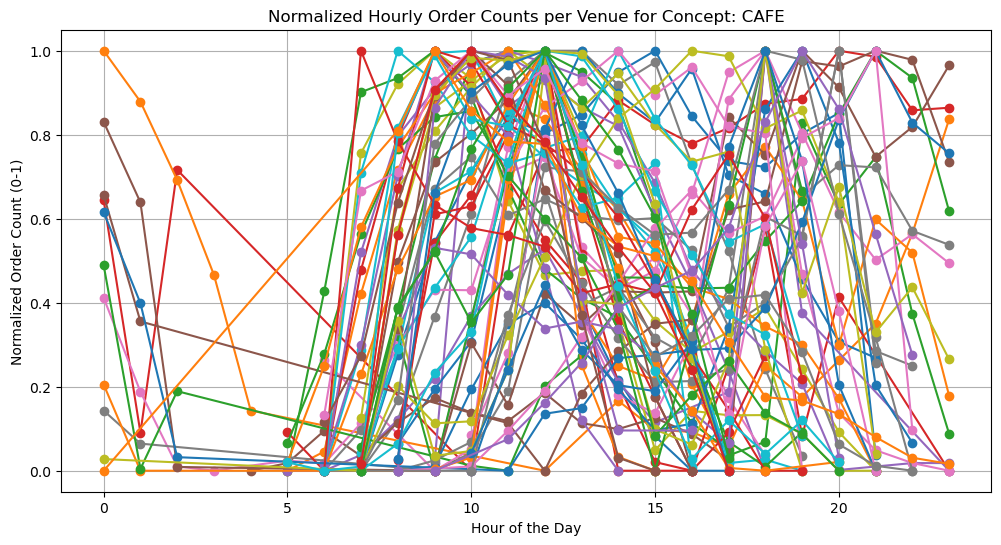

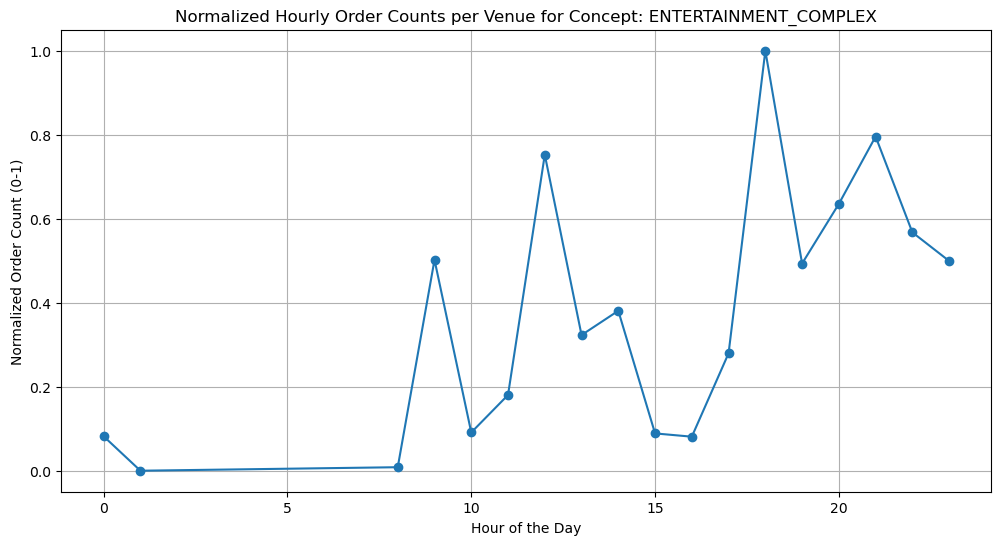

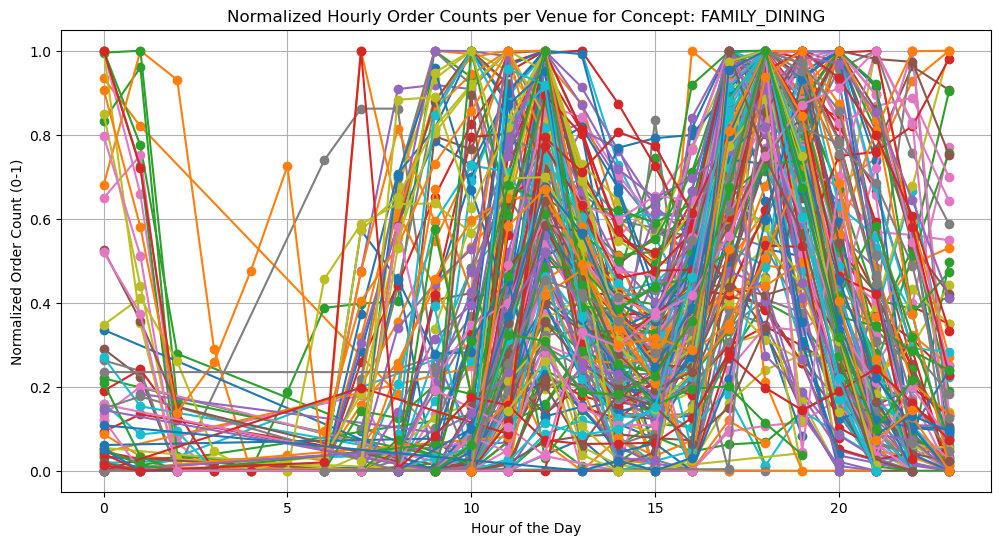

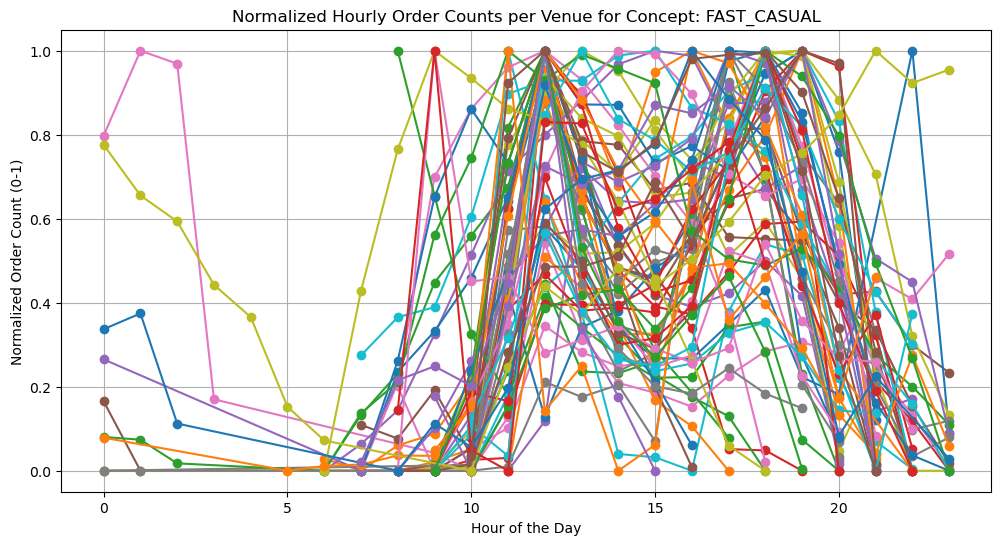

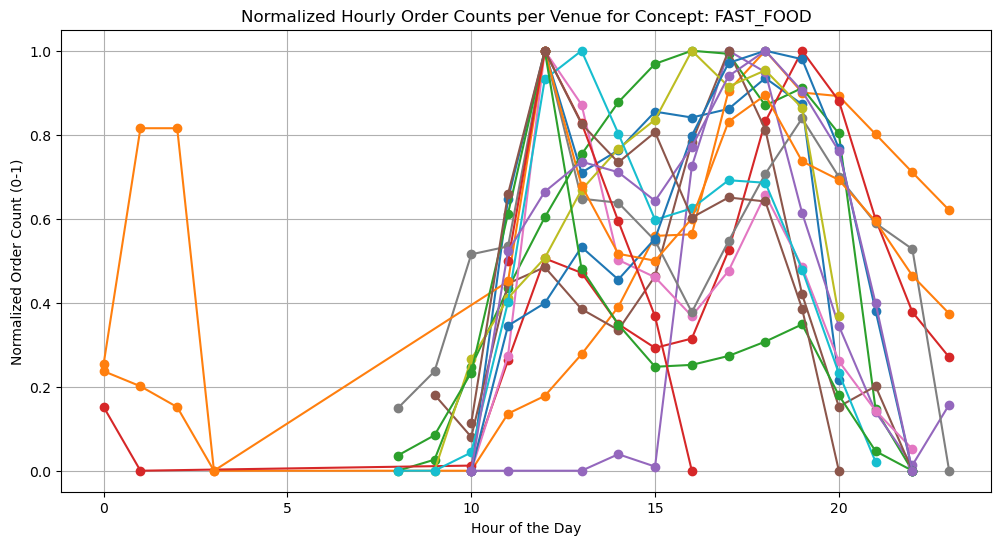

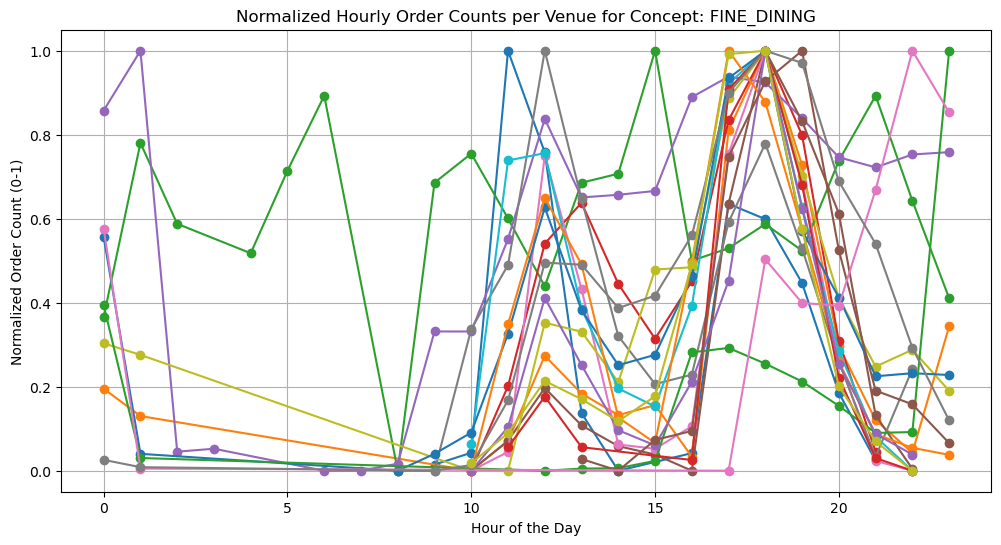

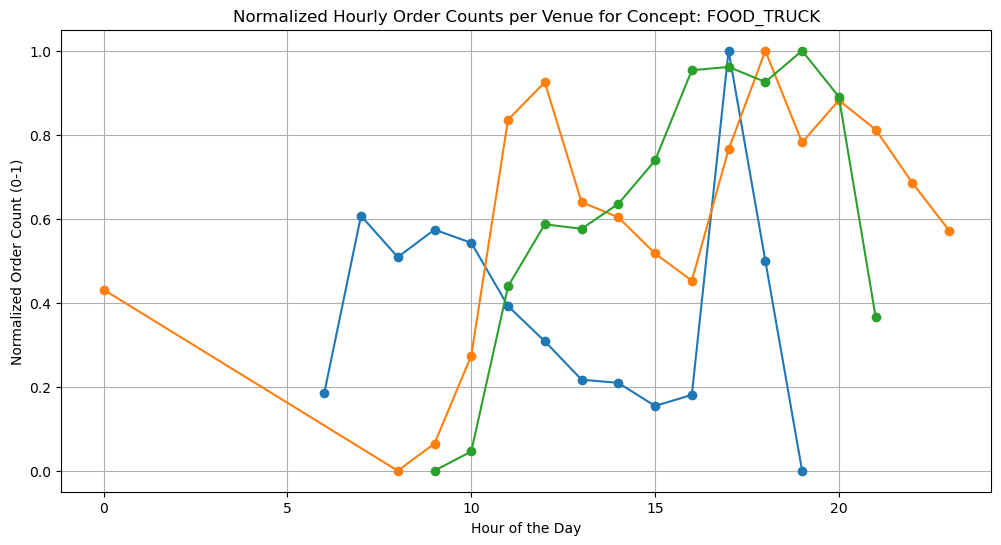

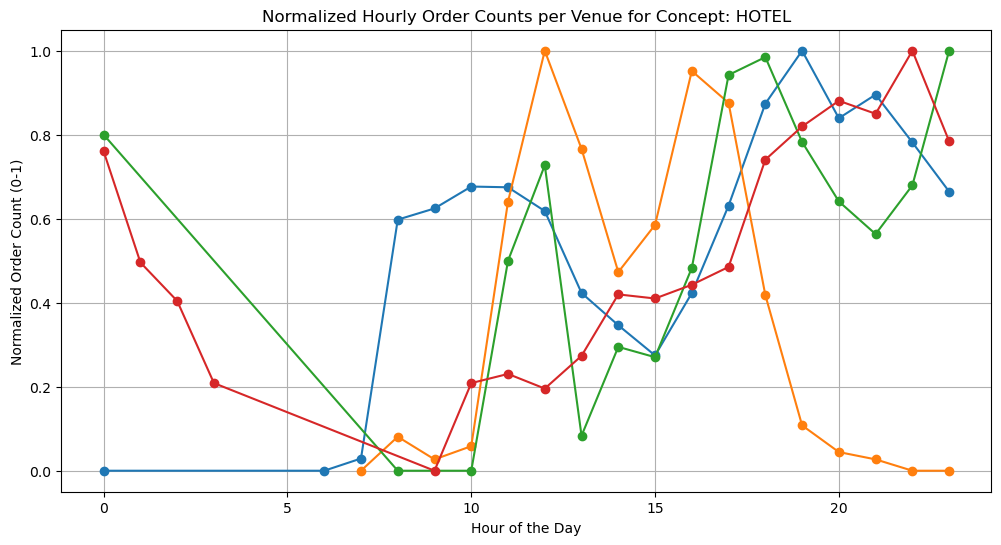

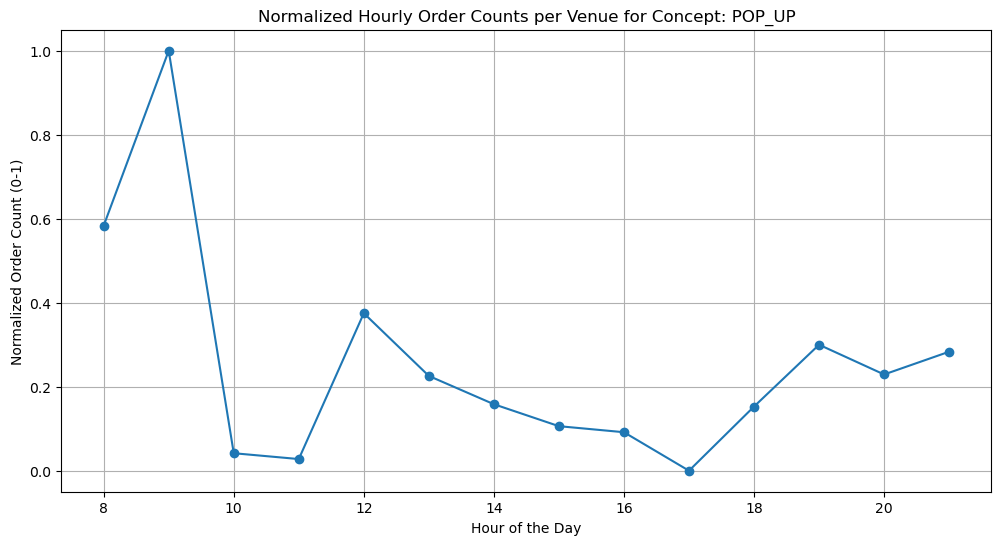

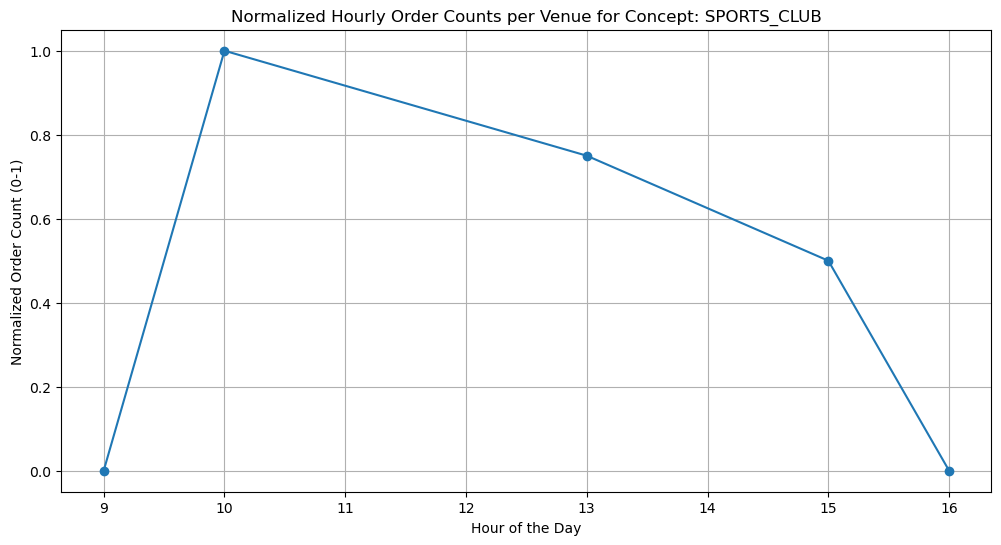

In [11]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize order counts per venue (not per concept)
average_hourly_order_counts['normalized_order_count'] = average_hourly_order_counts.groupby(['concept', 'venue_xref_id'])['order_count'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Plot the normalized hourly order counts
concepts = average_hourly_order_counts['concept'].unique()
for concept in concepts:
    plt.figure(figsize=(12, 6))
    concept_data = average_hourly_order_counts[average_hourly_order_counts['concept'] == concept]
    for venue in concept_data['venue_xref_id'].unique():
        venue_data = concept_data[concept_data['venue_xref_id'] == venue]
        plt.plot(venue_data['hour'], venue_data['normalized_order_count'], marker='o')  # Removed label

    plt.title(f'Normalized Hourly Order Counts per Venue for Concept: {concept}')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Normalized Order Count (0-1)')
    plt.grid(True)
    plt.show()


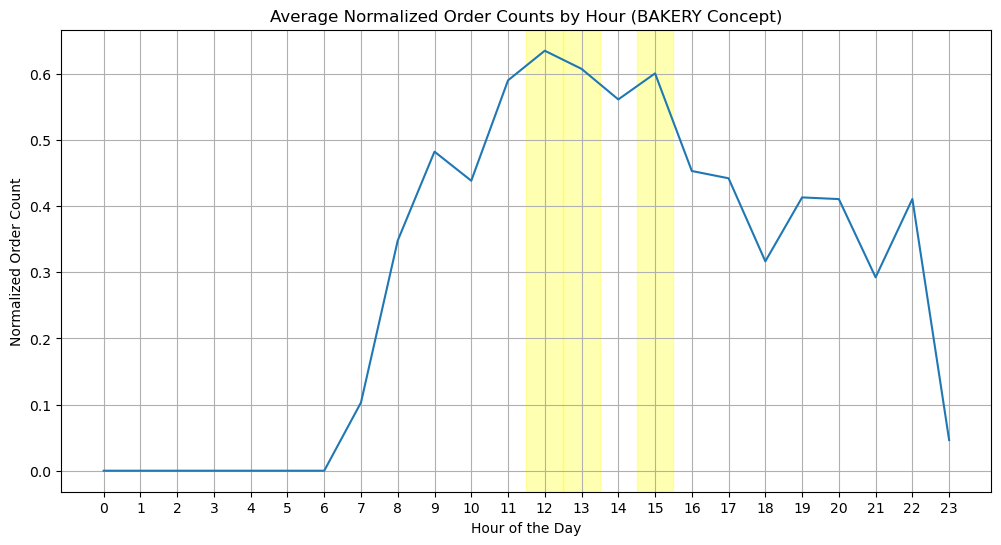

Peak hours for BAKERY concept:
    hour  normalized_order_count
7     12                0.634937
8     13                0.607528
10    15                0.600671




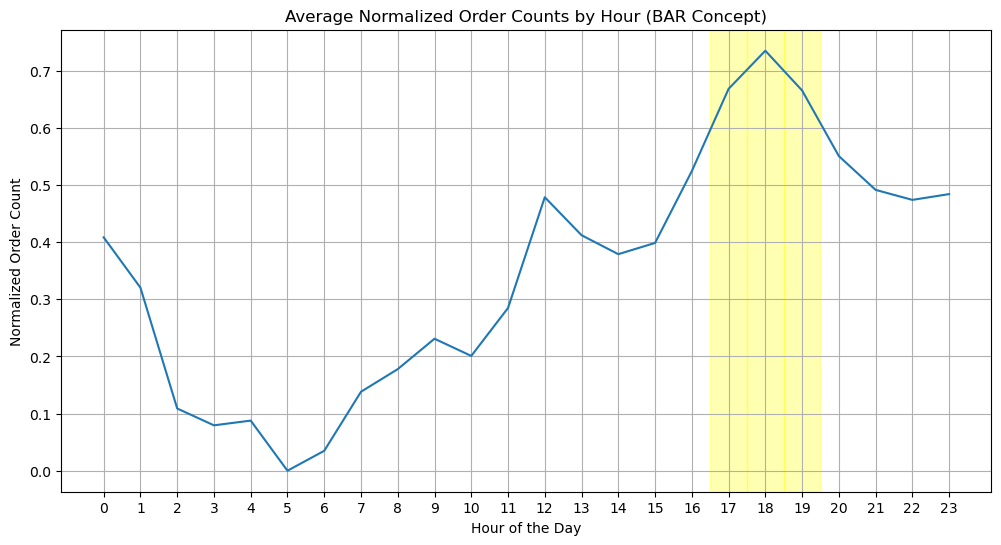

Peak hours for BAR concept:
    hour  normalized_order_count
37    18                0.735273
36    17                0.668522
38    19                0.665670




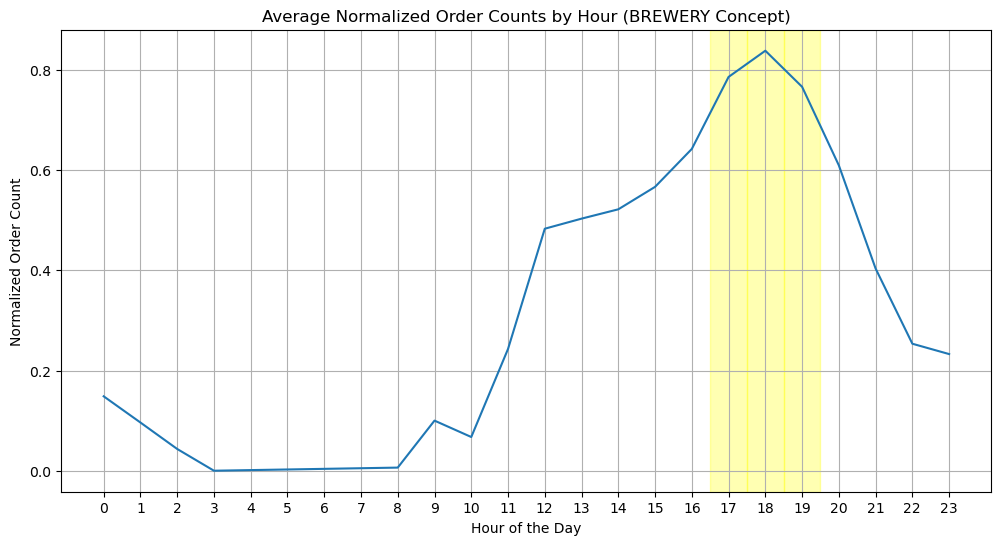

Peak hours for BREWERY concept:
    hour  normalized_order_count
57    18                0.838357
56    17                0.786052
58    19                0.766329




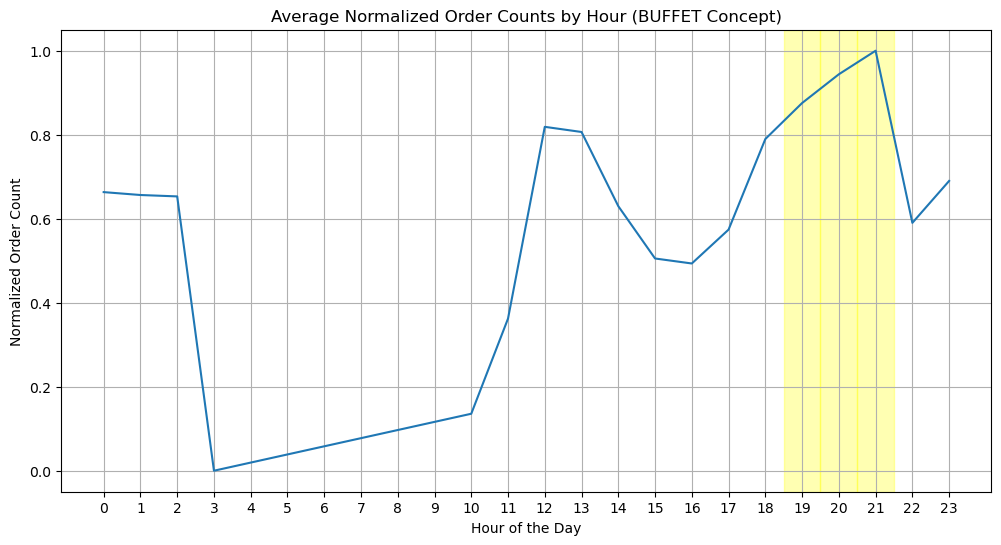

Peak hours for BUFFET concept:
    hour  normalized_order_count
78    21                1.000000
77    20                0.943933
76    19                0.875434




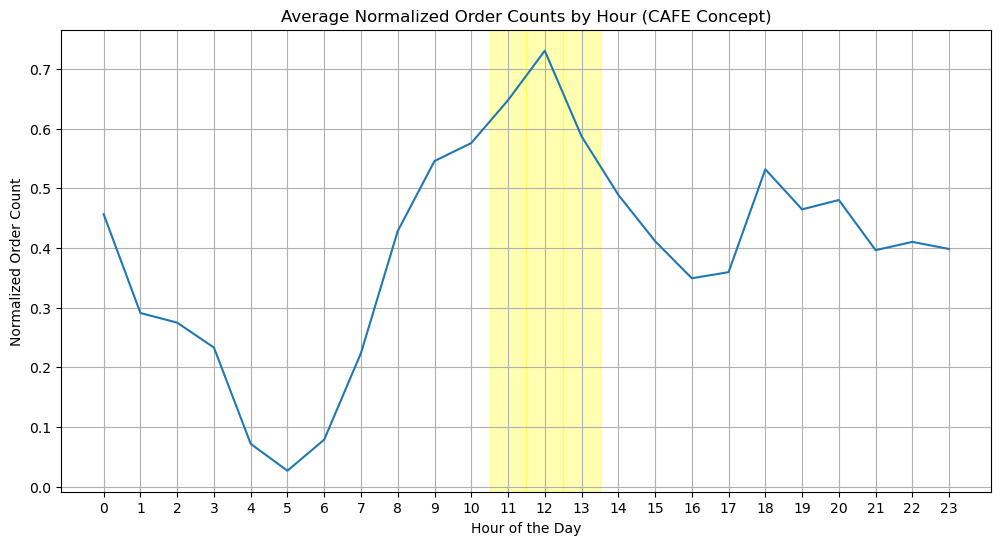

Peak hours for CAFE concept:
    hour  normalized_order_count
93    12                0.730620
92    11                0.647684
94    13                0.587200




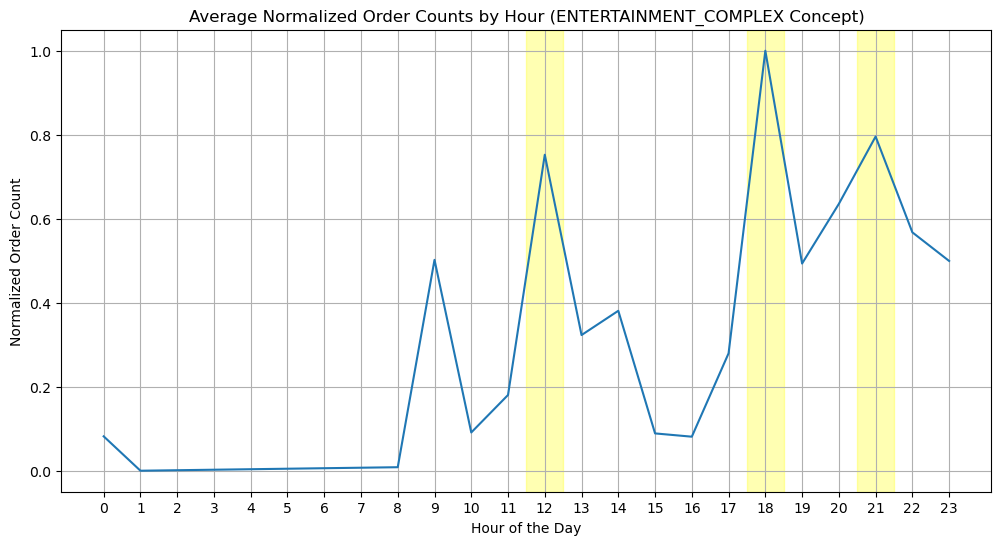

Peak hours for ENTERTAINMENT_COMPLEX concept:
     hour  normalized_order_count
117    18                1.000000
120    21                0.795688
111    12                0.752404




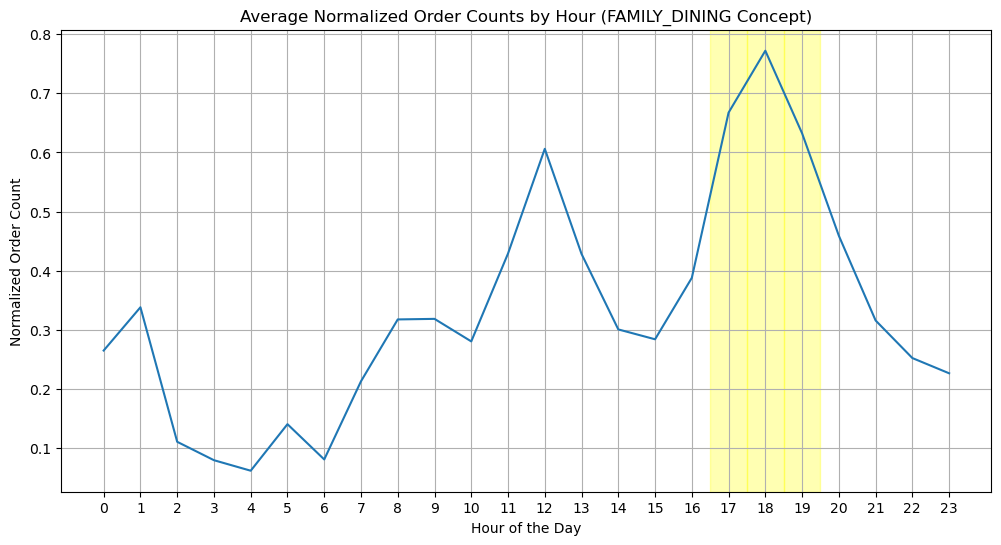

Peak hours for FAMILY_DINING concept:
     hour  normalized_order_count
141    18                0.771987
140    17                0.667347
142    19                0.632338




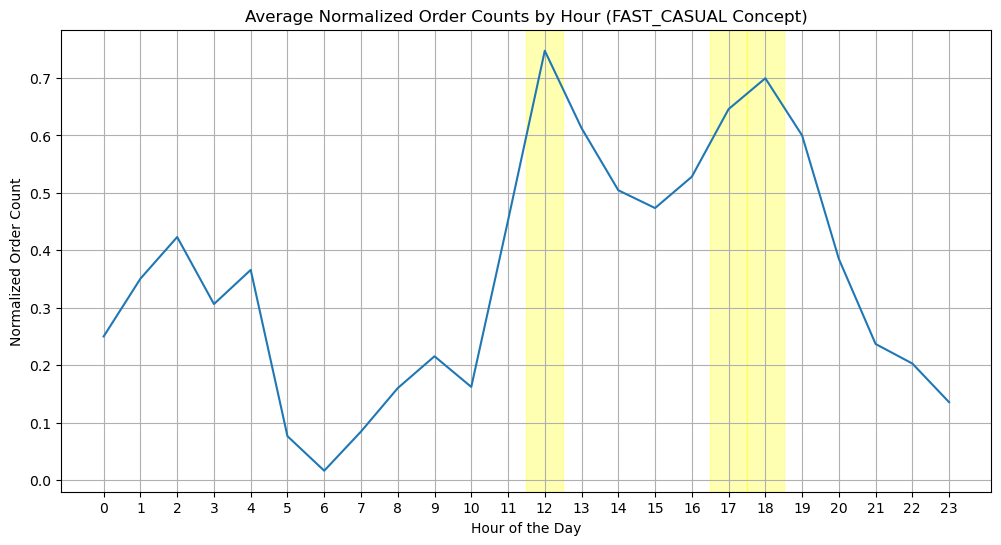

Peak hours for FAST_CASUAL concept:
     hour  normalized_order_count
159    12                0.747688
165    18                0.699725
164    17                0.645947




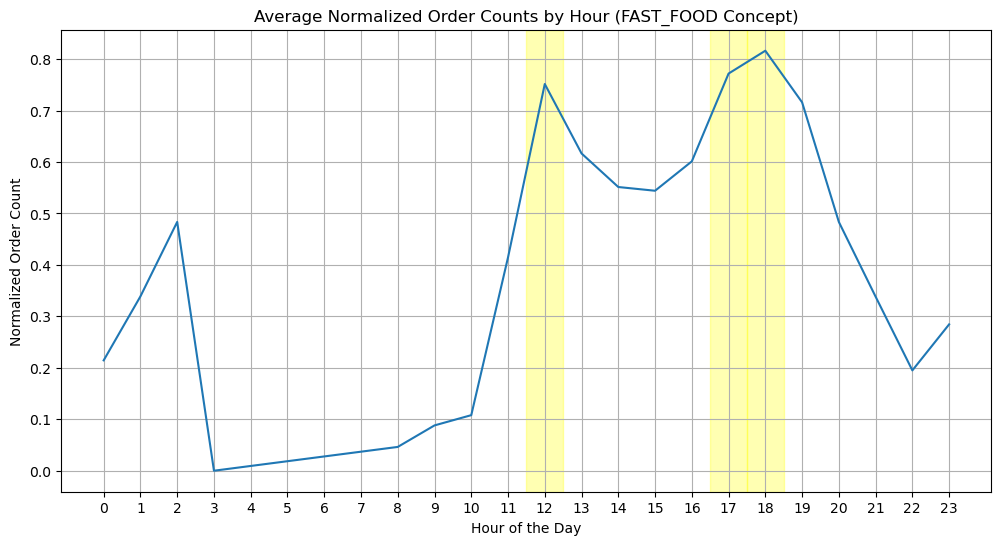

Peak hours for FAST_FOOD concept:
     hour  normalized_order_count
185    18                0.816249
184    17                0.771871
179    12                0.751566




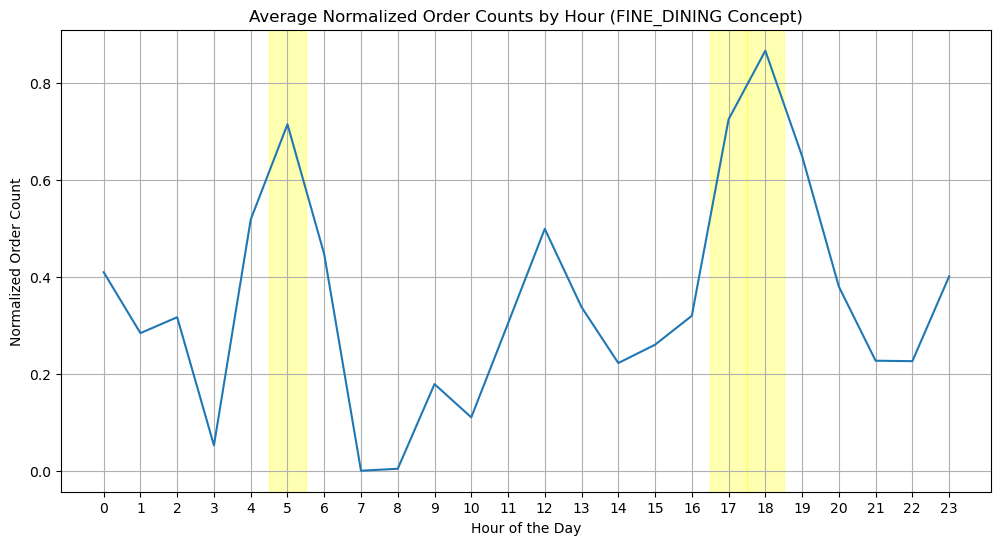

Peak hours for FINE_DINING concept:
     hour  normalized_order_count
209    18                0.865934
208    17                0.724526
196     5                0.714286




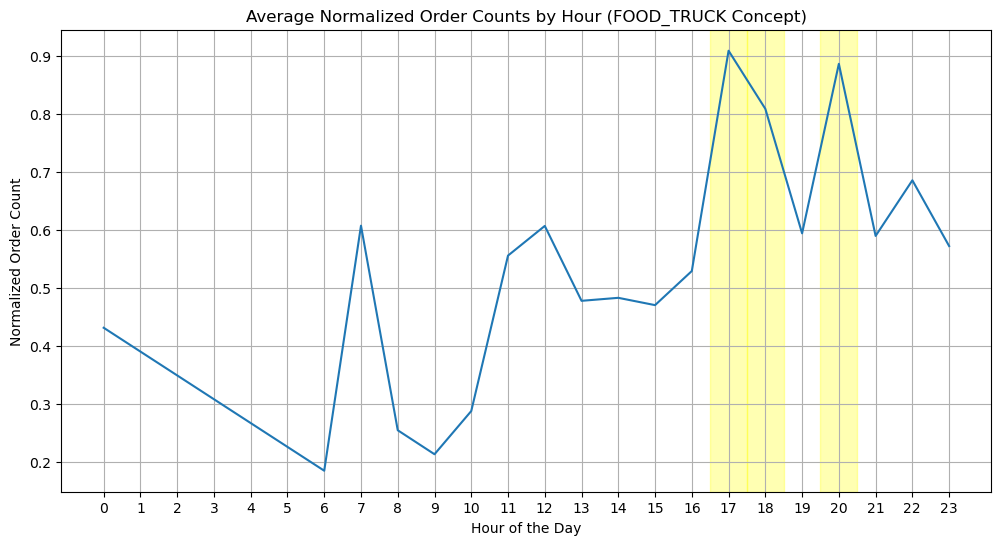

Peak hours for FOOD_TRUCK concept:
     hour  normalized_order_count
227    17                0.908761
230    20                0.886194
228    18                0.808557




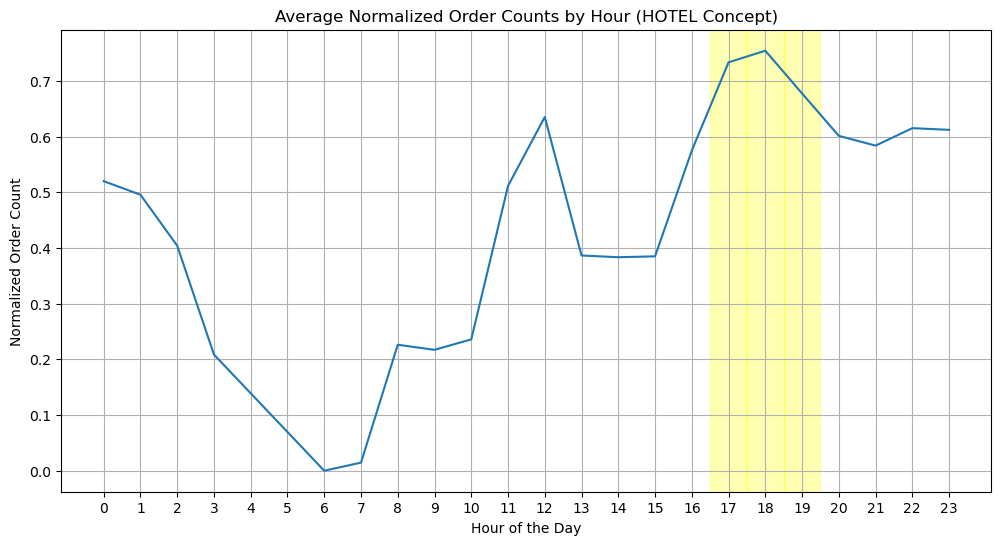

Peak hours for HOTEL concept:
     hour  normalized_order_count
250    18                0.754375
249    17                0.733576
251    19                0.677579




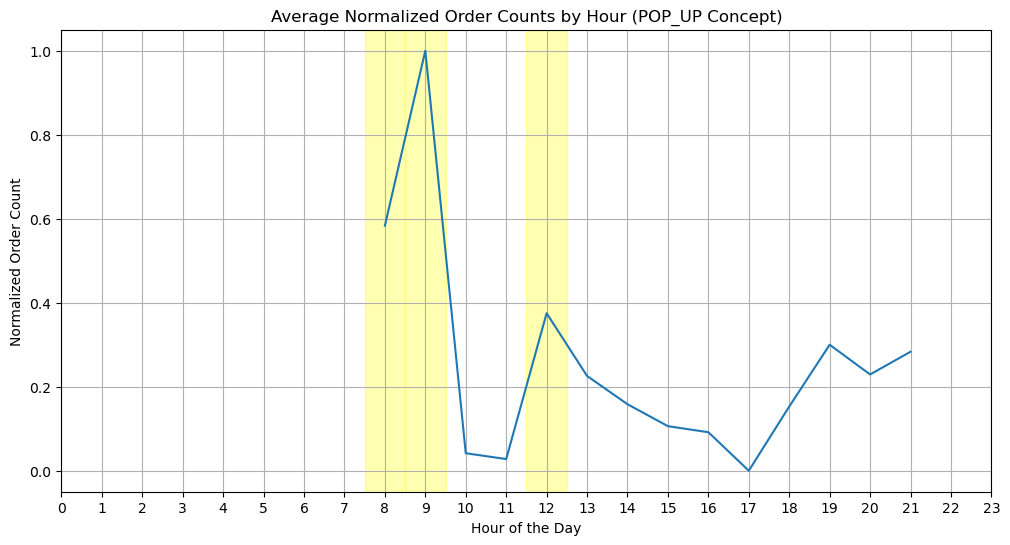

Peak hours for POP_UP concept:
     hour  normalized_order_count
257     9                1.000000
256     8                0.583333
260    12                0.375000




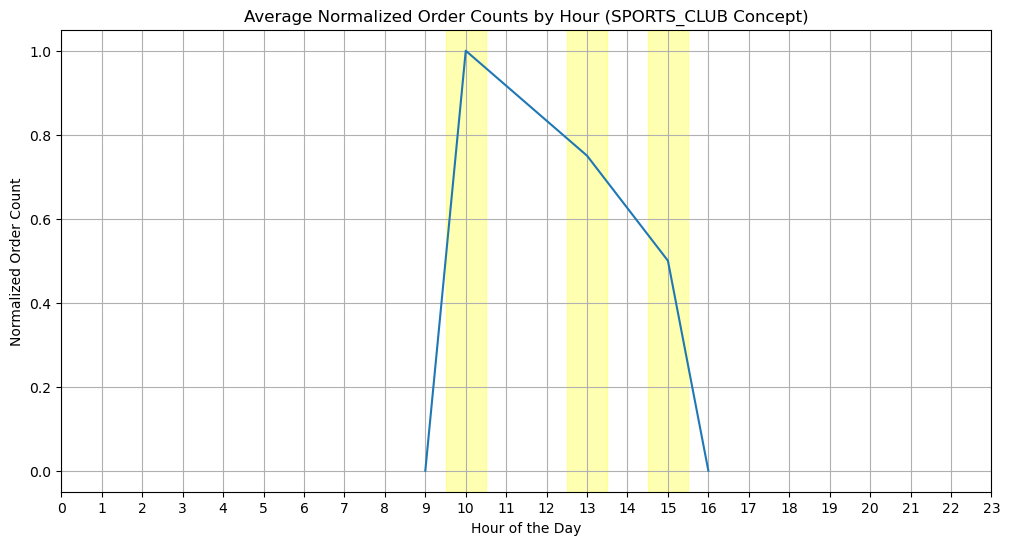

Peak hours for SPORTS_CLUB concept:
     hour  normalized_order_count
271    10                    1.00
272    13                    0.75
273    15                    0.50




In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate by concept and hour
concept_hourly_avg = (
    average_hourly_order_counts.groupby(['concept', 'hour'])['normalized_order_count'].mean().reset_index()
)

# Iterate over each unique concept and generate plots
concepts = concept_hourly_avg['concept'].unique()

for concept in concepts:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=concept_hourly_avg[concept_hourly_avg['concept'] == concept], 
                 x='hour', y='normalized_order_count')
    
    # Find peak hours (e.g., top 3 busiest hours)
    peak_hours = concept_hourly_avg[concept_hourly_avg['concept'] == concept].nlargest(3, 'normalized_order_count')
    
    # Highlight and shade the peak hours
    for _, row in peak_hours.iterrows():
        plt.axvspan(row['hour'] - 0.5, row['hour'] + 0.5, color='yellow', alpha=0.3)
    
    plt.title(f'Average Normalized Order Counts by Hour ({concept} Concept)')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Normalized Order Count')
    plt.grid(True)
    plt.xticks(range(0, 24))  # Ensure all hours are displayed
    plt.show()

    print(f"Peak hours for {concept} concept:")
    print(peak_hours[['hour', 'normalized_order_count']])
    print("\n" + "="*40 + "\n")


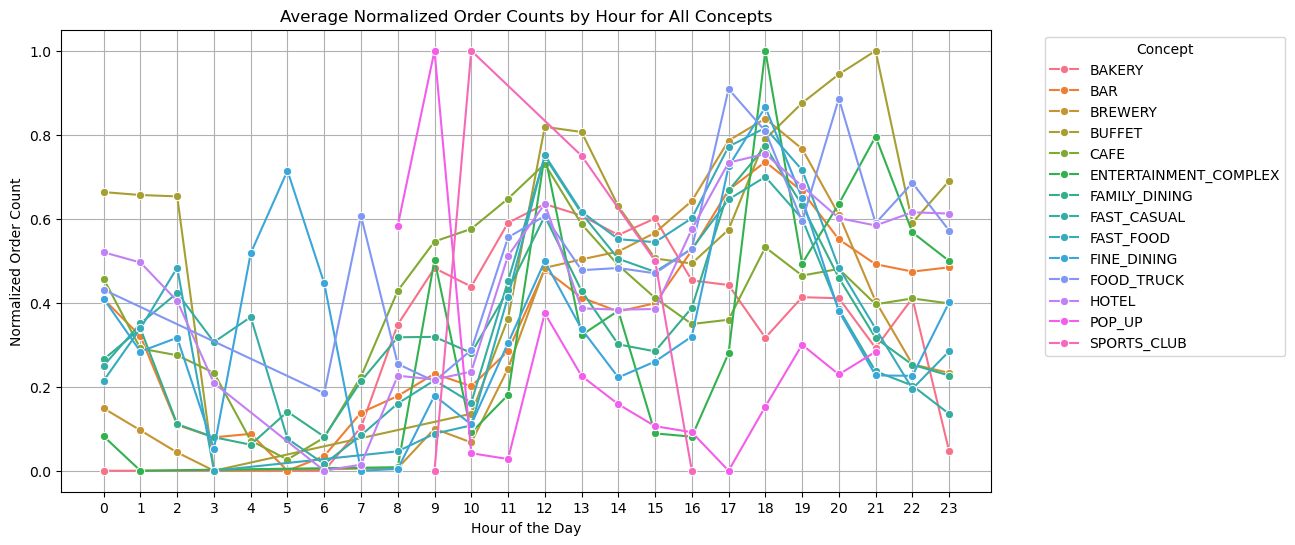

Peak hours for each concept:
                  concept  hour  normalized_order_count
0                  BAKERY    12                0.634937
1                  BAKERY    13                0.607528
2                  BAKERY    15                0.600671
3                     BAR    18                0.735273
4                     BAR    17                0.668522
5                     BAR    19                0.665670
6                 BREWERY    18                0.838357
7                 BREWERY    17                0.786052
8                 BREWERY    19                0.766329
9                  BUFFET    21                1.000000
10                 BUFFET    20                0.943933
11                 BUFFET    19                0.875434
12                   CAFE    12                0.730620
13                   CAFE    11                0.647684
14                   CAFE    13                0.587200
15  ENTERTAINMENT_COMPLEX    18                1.000000
16  ENTERTAINMENT_C

C:\Users\Natha\AppData\Local\Temp\ipykernel_21736\2961469894.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(3, 'normalized_order_count'))


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Aggregate by concept and hour
concept_hourly_avg = (
    average_hourly_order_counts.groupby(['concept', 'hour'])['normalized_order_count'].mean().reset_index()
)

# Plot all concepts together
plt.figure(figsize=(12, 6))
sns.lineplot(data=concept_hourly_avg, x='hour', y='normalized_order_count', hue='concept', marker='o')

plt.title('Average Normalized Order Counts by Hour for All Concepts')
plt.xlabel('Hour of the Day')
plt.ylabel('Normalized Order Count')
plt.grid(True)
plt.xticks(range(0, 24))  # Ensure all hours are displayed
plt.legend(title="Concept", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside for better readability
plt.show()

# Find peak hours for each concept (top 3 busiest hours)
peak_hours_per_concept = (
    concept_hourly_avg.groupby('concept')
    .apply(lambda x: x.nlargest(3, 'normalized_order_count'))
    .reset_index(drop=True)
)

print("Peak hours for each concept:")
print(peak_hours_per_concept[['concept', 'hour', 'normalized_order_count']])
